# Importations

In [1]:
import os
import cvxopt
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Data Preparation

L'EURO STOXX 50 est un indice boursier des valeurs de la zone euro conçu par STOXX, un fournisseur d'indices appartenant au groupe Deutsche Börse. L'indice est composé de 50 actions provenant de 11 pays de la zone euro. L'EURO STOXX 50 représente les sociétés de premier ordre de la zone euro considérées comme leaders dans leurs secteurs respectifs.

In [2]:
# Loading Euro Stoxx 50 Index (stoxx50)
sx5e=pd.ExcelFile('Euro Stoxx 50 Index.xlsx').parse('sx5e')
sx5e.set_index('Date',inplace=True)
sx5e.index=pd.to_datetime(sx5e.index)
sx5e.columns=['SX5E']

In [3]:
# Loading the 50 composites (independently)
df=pd.ExcelFile('Euro Stoxx 50 Index.xlsx').parse('composite price')
df.set_index('date',inplace=True)

components=df.columns.tolist()

In [5]:
# Merging the 2 sheets
metadata=df.merge(sx5e,left_index=True,right_index=True,how='inner')

Nous choisissons une répartition 60/40 et fixons 2014 à 2016 comme horizon de formation, 2017 à 2018 comme horizon de test.

In [6]:
# In-sample data: 60%
data_in = metadata['2014':'2016'].copy()

# Out-sample data: 60%
data_out = metadata['2017':].copy()

In [7]:
# Calculate percentage return
pct_return = data_in.pct_change().dropna()

# Calculate correlation
correlation = pct_return[components].corr()

#Graph Construction

Nous représentons les noeuds par les 50 composites. La corrélation entre le rendement moyen de deux actions est désignée par les poids. Ce n'est que si la corrélation dépasse le seuil prédéfini que nous établissons une arête non dirigée entre deux sommets.

Les valeurs aberrantes sont des actions individuelles qui n'ont pas de corrélation supérieure au seuil avec d'autres actions.

In [8]:
# Create the Graph data structure
def create_graph(components,correlation,threshold):

    graph=nx.Graph()

    #connect two vertices if correlation larger than the threshold
    for i in range(len(components)):
        for j in range(i+1,len(components)):
            if correlation.at[components[i],components[j]]>threshold:
                graph.add_edge(components[i],components[j],
                               weight=correlation.at[components[i],components[j]])
                graph.add_edge(components[j],components[i],
                               weight=correlation.at[components[i],components[j]])

    #fix layout for viz
    layout=nx.spring_layout(graph)

    return graph,layout

##Degeneracy Ordering

Au-delà des valeurs aberrantes du graphe, un autre aspect est également important. Même au sein de composantes fortement connectées, il est possible de choisir des actifs faiblement corrélés. Dans le domaine de la théorie des graphes, ces sommets choisis sont appelés "ensemble de sommets indépendants", un sous-ensemble dans lequel deux sommets ne partagent pas d'adjacence. En règle générale, il existe plusieurs ensembles de sommets indépendants maximaux, ce qui soulève la question suivante : quels sont les critères qui guident notre sélection ?

Pour répondre à cette question, nous adoptons un concept issu de K-core, connu sous le nom d'ordre de dégénérescence. L'ordre de dégénérescence implique l'identification itérative et la suppression du sommet ayant le plus petit degré du graphe ADT. Dans ce contexte, la dégénérescence est le degré le plus élevé d'un sommet au moment de son retrait.

In [10]:
# Find the maximal independent vertex set
def degeneracy_ordering(graph,components):

    #degeneracy ordering
    degeneracy=dict(sorted(nx.core_number(graph).items(),
                           key=lambda x:x[1]))


    independence=[]
    for i in degeneracy:
        if not set(graph.neighbors(i)).intersection(set(independence)):
            independence.append(i)


    leftout=[i for i in components if i not in graph.nodes]

    return independence,leftout

In [11]:
# Find Optimal Threshold for correlation
def find_optimal_threshold(itr,data,components,correlation):

    optimal=[]
    for threshold_itr in itr:

        graph,_=create_graph(components,correlation,threshold_itr)
        independence,leftout=degeneracy_ordering(graph,components)

        #compute sharpe ratio
        temp=data[leftout+independence].sum(axis=1).pct_change().dropna()
        optimal.append(temp.mean()/temp.std())

    #viz
    ax=plt.figure(figsize=(10,5)).add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.bar(np.arange(0.5,0.7,0.01),optimal,
            width=0.008,color='#F9CDAD')
    plt.title('Optimal Correlation')
    plt.xlabel('Correlation')
    plt.ylabel('Sharpe Ratio')
    plt.show()

Si nous itérons différents nombres possibles du seuil de corrélation, le résultat empirique indiquera que 0,6 est effectivement le seuil optimal pour la corrélation. Lorsque le seuil est fixé à 0,6, nous attribuons un poids égal à notre ensemble de sommets indépendants et aux valeurs aberrantes pour construire un nouveau portefeuille appelé indice de dégénérescence. Le nouveau portefeuille à 0,6 produit le ratio de Sharpe le plus élevé parmi les autres scénarios.

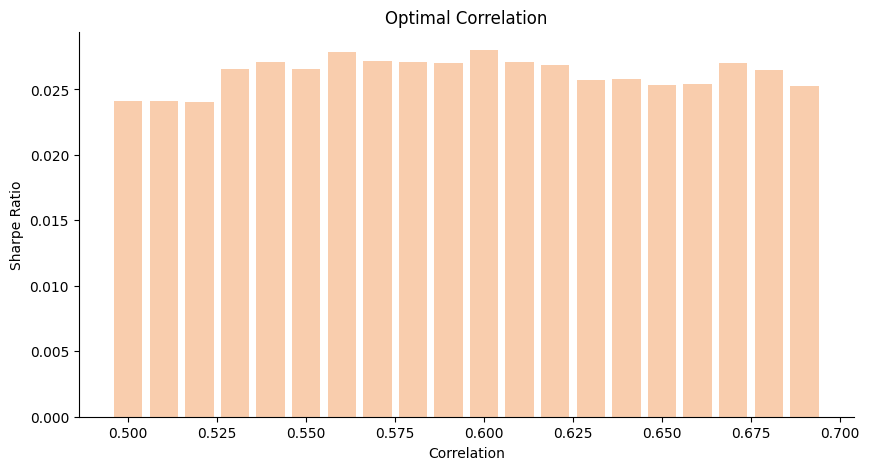

In [13]:
find_optimal_threshold(np.arange(0.5,0.7,0.01),
                       data_in,components,correlation)

La figure ci-dessous identifie notre ensemble de sommets indépendants dans le graphe:

In [14]:
graph,layout=create_graph(components,correlation,threshold=0.6)

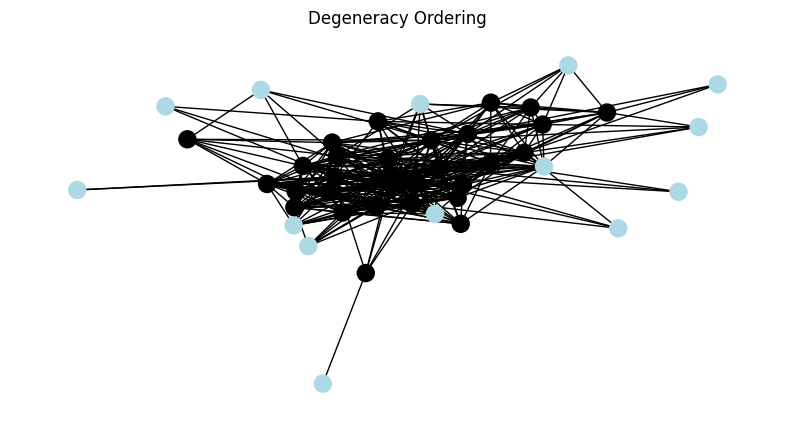

In [20]:
independence,leftout=degeneracy_ordering(graph,components)
data_in['degeneracy']=data_in[leftout+independence].sum(axis=1)

#highlight selected vertices
color=[]
for i in graph.nodes:
    if i not in independence:
        color.append('#000000')
    else:
        color.append('lightblue')

#viz graph
ax=plt.figure(figsize=(10,5)).add_subplot(111)
nx.draw(graph,node_color=color,pos=layout,node_size=150)
plt.title('Degeneracy Ordering')
plt.show()

L'ensemble des sommets indépendants contient les entreprises ci-dessous:


* CRH PLC
* Deutsche Boerse AG
* Fresenius SE & Co KGaA
* Intesa Sanpaolo SpA
* Kering SA
* Linde PLC
* Orange SA
* SAP SE
* Safran SA
* Sanofi SA
* TOTAL SA
* Unilever NV
* Vinci SA
* Volkswagen AG



## Clique Centrality

La deuxième idée est l'inverse de la diversification. Nous essayons de trouver la combinaison d'actifs la plus concentrée pour remplacer l'indice de référence Euro Stoxx 50. En supposant que l'élimination des actifs inutiles puisse augmenter le rendement, nous nous concentrons sur plusieurs actions individuelles. Pour sélectionner la combinaison d'actifs fortement corrélée, nous devons proposer un concept relativement avancé - la centralité de la clique maximale croisée. La centralité est définie comme suit. Le nombre de cliques maximales qui contiennent un sommet donné est la centralité de la clique maximale croisée du sommet donné. Le raisonnement intuitif est simple. Les sommets qui apparaissent fréquemment dans de nombreuses cliques maximales doivent être les plus influents. En général, il semble que la centralité de clique indique l'intégration dans des régions denses d'un graphe (Everett et Borgatti, 1998). Cette centralité est simplement appelée **Centralité de Clique Maximale**.

In [21]:
def clique_centrality(graph,centrality):

    #compute cross maximal clique centrality
    cliques=list(nx.find_cliques(graph))

    D={}
    for ii in set([j for i in cliques for j in i]):
        D[ii]=[j for i in cliques for j in i].count(ii)

    #select vertices with centrality larger than the threshold
    clique_selected=[i[0] for i in D.items() if i[1]>centrality]

    return clique_selected

In [23]:
#use cross maximal clique centrality to construct the portfolio
clique_selected=clique_centrality(graph,centrality=10)
data_in['clique']=data_in[clique_selected].sum(axis=1)

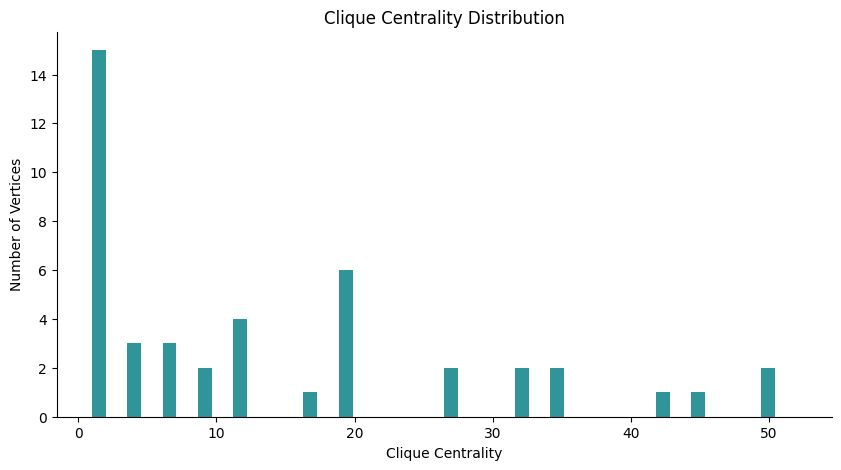

In [24]:
#viz clique centrality distribution
cliques=list(nx.find_cliques(graph))
dic={}
for ii in set([j for i in cliques for j in i]):
    dic[ii]=[j for i in cliques for j in i].count(ii)

#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.hist(dic.values(),width=1,bins=20,color='#2F9599')

plt.title('Clique Centrality Distribution')
plt.xlabel('Clique Centrality')
plt.ylabel('Number of Vertices')
plt.show()

La distribution de la centralité des cliques maximales croisées indique que 10 n'est pas un mauvais choix pour le seuil.

En fixant le seuil à 10, nous sommes en mesure d'obtenir la combinaison hautement concentrée ci-dessous. Nous attribuons un poids égal à chaque composite pour construire un nouveau portefeuille appelé Indice Clique.

La figure ci-dessous montre que notre combinaison est située au cœur même du graphique.

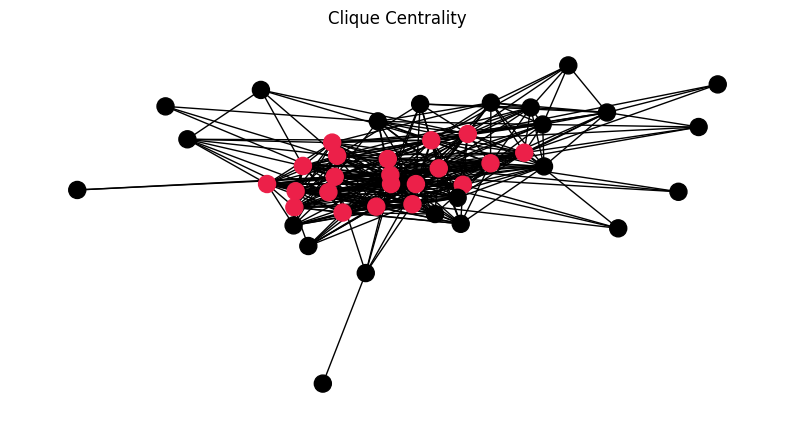

In [25]:
#highlight selected vertices
color=[]
for i in graph.nodes:
    if i not in clique_selected:
        color.append('#000000')
    else:
        color.append('#EC2049')

#viz graph
ax=plt.figure(figsize=(10,5)).add_subplot(111)
nx.draw(graph,node_color=color,pos=layout,node_size=150)
plt.title('Clique Centrality')
plt.show()

In [26]:
#find optimal threshold for correlation and centrality
def find_optimal_heat(itr1,itr2,data,components,correlation):

    #create dataframe for heatmap
    heat=pd.DataFrame(index=itr1)
    for i in itr2:
        heat[round(i,2)]=np.nan

    for threshold_itr in itr2:
        for centrality_itr in itr1:

            graph,_=create_graph(components,correlation,threshold_itr)
            cliques=list(nx.find_cliques(graph))

            #efficient execution when no clique is found
            if cliques:

                #compute cross maximal clique centrality
                clique_selected=clique_centrality(graph,centrality_itr)

                #compute sharpe ratio
                temp=data[clique_selected].sum(axis=1).pct_change().dropna()
                heat.at[round(centrality_itr,2),
                        round(threshold_itr,2)]=temp.mean()/temp.std()
            else:
                pass

    #viz
    heatmap(heat)


#create heatmap seaborn style
def heatmap(df,fig_size=(10,5),fontsize=0.8):

    fig=plt.figure(figsize=fig_size)
    ax=fig.add_subplot(111)

    sns.set(font_scale=fontsize)

    #viz
    sns.heatmap(df,cmap=plt.cm.magma_r,
                robust=True,
                xticklabels=df.columns,
                yticklabels=df.index,
                ax=ax)

    #color bar title
    ax.collections[0].colorbar.set_label('Sharpe Ratio\n \n',rotation=270)

    plt.title('Optimal Correlation & Centrality')
    plt.xlabel('Correlation')
    plt.ylabel('Centrality')
    sns.set()

    plt.show()
    plt.style.use('default')

Pour trouver les seuils optimaux à la fois pour la corrélation et la centralité de clique maximale croisée, nous appliquons un calcul de force brute pour essayer une corrélation de 0,5 à 0,7 et une centralité de 2 à 20. Pour atteindre le ratio de Sharpe maximal, les meilleurs seuils semblent être 0,5 et 2 pour la corrélation et la centralité.

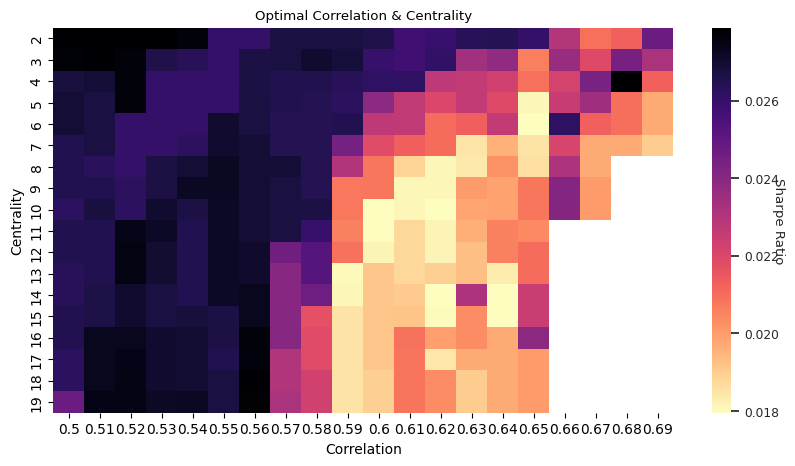

In [27]:
#viz optimal thresholds of correlation and centrality
find_optimal_heat(range(2,20),np.arange(0.5,0.7,0.01),
                  data_in,components,correlation)

##Markowitz Optimization

La théorie moderne du portefeuille a été introduite en 1952 par le lauréat du prix Nobel Harry Markowitz. L'idée était de trouver les allocations d'actifs qui fournissent le risque le plus faible possible pour tout niveau de rendement attendu. Il existe trois types de stratégies possibles en matière d'optimisation de portefeuille:
* Maximiser le ratio de Sharpe
* Minimiser la variance
* Maximiser le rendement

In [28]:
#Find the Global Maximum
def markowitz_optimization(pctreturn,components):

    #hide progress output
    cvxopt.solvers.options['show_progress']=False

    #create covariance matrix
    covariance=cvxopt.matrix(np.cov(np.array(pctreturn[components].T)))

    #number of assets
    assets=len(components)

    #realized return
    mean_return=cvxopt.matrix(pctreturn[components].mean(axis=0))

    #all weights should be larger than 0
    inequality_coeff=cvxopt.matrix(0.0,(assets,assets))
    inequality_coeff[::assets+1]=-1.0
    inequality_value=cvxopt.matrix(0.0,(assets,1))

    #sum of all weights equal to one
    equality_coeff=cvxopt.matrix(1.0,(1,assets))
    equality_value=cvxopt.matrix(1.0)

    #risk aversion parameter
    miu=1

    #maximize sharpe ratio
    max_sharpe=cvxopt.solvers.qp(P=cvxopt.matrix(miu*covariance),
                                 q=-mean_return,
                                 G=inequality_coeff,
                                 h=inequality_value,
                                 A=equality_coeff,
                                 b=equality_value)['x']

    #minimize standard deviation
    min_variance=cvxopt.solvers.qp(P=cvxopt.matrix(covariance),
                           q=cvxopt.matrix(0.0,(assets,1)),
                           G=inequality_coeff,
                           h=inequality_value,
                           A=equality_coeff,
                           b=equality_value)['x']

    #maximize realized return
    max_return=cvxopt.solvers.qp(P=cvxopt.matrix(0.0,(assets,assets)),
                                 q=-mean_return,
                                 G=inequality_coeff,
                                 h=inequality_value,
                                 A=equality_coeff,
                                 b=equality_value)['x']

    return (max_sharpe,min_variance,max_return)

In [29]:
#markowitz portfolio optimization
max_sharpe,min_variance,max_return=markowitz_optimization(pct_return,components)
data_in['sharpe']=np.dot(np.mat(data_in[components]),np.mat(max_sharpe)).reshape(-1,).tolist()[0]
data_in['variance']=np.dot(np.mat(data_in[components]),np.mat(min_variance)).reshape(-1,).tolist()[0]
data_in['return']=np.dot(np.mat(data_in[components]),np.mat(max_return)).reshape(-1,).tolist()[0]

#create equal weight index
data_in['equal']=data_in[components].sum(axis=1)

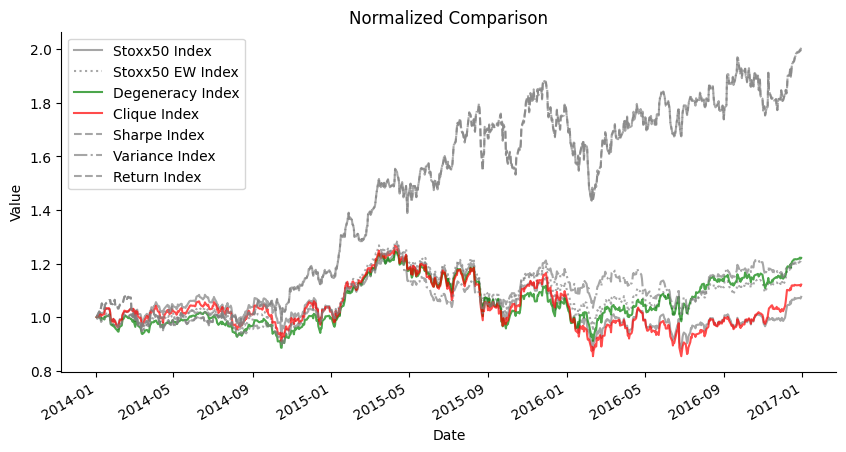

In [30]:
#normalized comparison
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

(data_in['SX5E']/data_in['SX5E'].iloc[0]).plot(label='Stoxx50 Index',alpha=0.7,color='grey')
(data_in['equal']/data_in['equal'].iloc[0]).plot(label='Stoxx50 EW Index',alpha=0.7,color='grey',linestyle=':')
(data_in['degeneracy']/data_in['degeneracy'].iloc[0]).plot(label='Degeneracy Index',alpha=0.7,color='green')
(data_in['clique']/data_in['clique'].iloc[0]).plot(label='Clique Index',alpha=0.7,color='red')
(data_in['sharpe']/data_in['sharpe'].iloc[0]).plot(label='Sharpe Index',alpha=0.7,color='grey',linestyle='--')
(data_in['variance']/data_in['variance'].iloc[0]).plot(label='Variance Index',alpha=0.7,color='grey',linestyle='-.')
(data_in['return']/data_in['return'].iloc[0]).plot(label='Return Index',alpha=0.7,color='grey',linestyle='--')

plt.legend(loc=0)
plt.title('Normalized Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

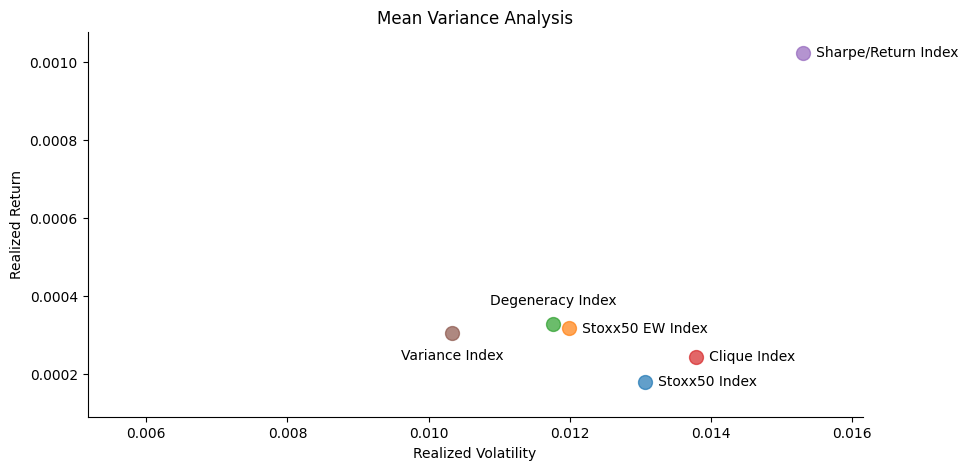

In [31]:
# Mean Variance Analysis
comparison={}

for i in ['SX5E','equal','degeneracy','clique','sharpe','variance','return']:
    comparison[i]=(data_in[i].pct_change().dropna().std(),
          data_in[i].pct_change().dropna().mean())

#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.scatter(comparison['SX5E'][0],comparison['SX5E'][1],
            s=100,alpha=0.7)
plt.annotate(xy=(comparison['SX5E'][0],comparison['SX5E'][1]),
             text='   Stoxx50 Index',ha='left',va='center')
plt.scatter(comparison['equal'][0],comparison['equal'][1],
            s=100,alpha=0.7)
plt.annotate(xy=(comparison['equal'][0],comparison['equal'][1]),
             text='   Stoxx50 EW Index',ha='left',va='center')
plt.scatter(comparison['degeneracy'][0],comparison['degeneracy'][1],
            s=100,alpha=0.7)
plt.annotate(xy=(comparison['degeneracy'][0],comparison['degeneracy'][1]),
             text='Degeneracy Index\n',ha='center',va='bottom')
plt.scatter(comparison['clique'][0],comparison['clique'][1],
            s=100,alpha=0.7)
plt.annotate(xy=(comparison['clique'][0],comparison['clique'][1]),
             text='   Clique Index',ha='left',va='center')
plt.scatter(comparison['sharpe'][0],comparison['sharpe'][1],
            s=100,alpha=0.7)
plt.annotate(xy=(comparison['sharpe'][0],comparison['sharpe'][1]),
             text='   Sharpe/Return Index',ha='left',va='center')
plt.scatter(comparison['variance'][0],comparison['variance'][1],
            s=100,alpha=0.7)
plt.annotate(xy=(comparison['variance'][0],comparison['variance'][1]),
             text='\nVariance Index',ha='center',va='top')

plt.xlim(min([i[0] for i in comparison.values()])*0.5,
         max([i[0] for i in comparison.values()])*1.05)
plt.ylim(min([i[1] for i in comparison.values()])*0.5,
         max([i[1] for i in comparison.values()])*1.05)
plt.title('Mean Variance Analysis')
plt.xlabel('Realized Volatility')
plt.ylabel('Realized Return')
plt.show()

#In-Sample data results

Pour la comparaison des données en échantillon, nous introduisons également un autre indice de référence, l'indice Euro Stoxx 50 Equal Weight.Nous soumettons tous les indices à l'analyse de la variance moyenne afin d'évaluer leur performance. Il semble que l'indice Sharpe/Rendement (étant donné qu'ils sont très similaires, nous les avons regroupés) soit toujours plus performant que les autres. C'est tout à fait normal car ces deux indices recherchent le maximum local de notre fonction donnée. De manière surprenante, l'indice Stoxx50 EW est toujours plus performant que l'indice Stoxx50 réel. L'indice Stoxx50 réel est calculé à l'aide de la formule de Laspeyres. Compte tenu de la capitalisation boursière et de la liquidité des actions de chaque indice composite, l'indice Stoxx50 penche fortement en faveur des entreprises ayant une capitalisation boursière plus importante et une plus grande liquidité des actions. D'une manière générale, ces sociétés de premier ordre sont plus susceptibles d'être corrélées à la situation macroéconomique générale. En d'autres termes, l'indice Stoxx50 est conçu pour pencher vers des actions fortement corrélées. L'indice Stoxx50 EW semble être un bien meilleur choix lors de la construction d'un portefeuille. Les actions moins corrélées ont des pondérations plus importantes dans le portefeuille. En termes de complexité temporelle, l'indice Stoxx50 EW l'emporte incontestablement sur tous les autres indices. L'indice de dégénérescence et l'indice de variance affichent la volatilité la plus faible de tous. En ce qui concerne la complexité temporelle linéaire de l'ordre de dégénérescence, il peut s'agir d'une bonne approximation de la recherche d'un portefeuille à variance minimale. Quant à l'indice de clique, c'est le canard boiteux de tous. Il présente l'une des complexités temporelles les plus élevées en raison de l'algorithme de recherche de cliques NP-hard.
 Il prouve que la diversification des actifs est nécessaire.

In [32]:
# Calculate percentage return
pct_return = data_out.pct_change().dropna()

# Calculate correlation
correlation = pct_return[components].corr()

# Graph Construction
graph,layout=create_graph(components,correlation,threshold=0.6)

In [33]:
#generate indices
data_out['degeneracy']=data_out[leftout+independence].sum(axis=1)
data_out['clique']=data_out[clique_selected].sum(axis=1)
data_out['sharpe']=np.dot(np.mat(data_out[components]),np.mat(max_sharpe)).reshape(-1,).tolist()[0]
data_out['variance']=np.dot(np.mat(data_out[components]),np.mat(min_variance)).reshape(-1,).tolist()[0]
data_out['return']=np.dot(np.mat(data_out[components]),np.mat(max_return)).reshape(-1,).tolist()[0]
data_out['equal']=data_out[components].sum(axis=1)

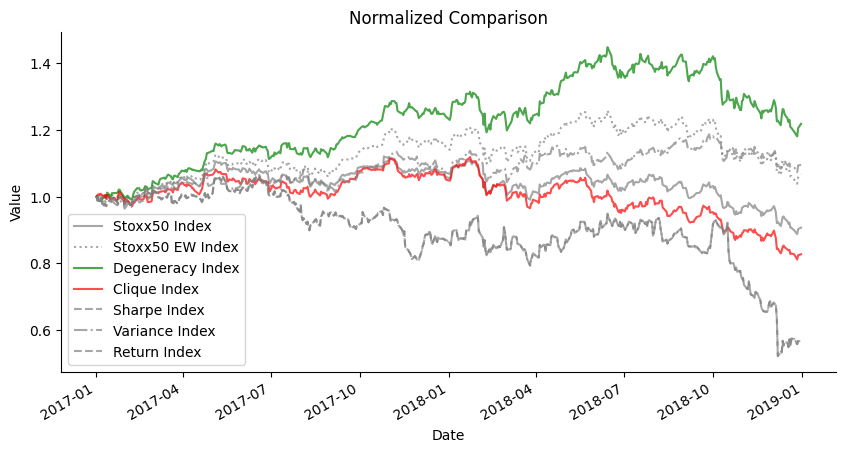

In [34]:
#normalized comparison
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

(data_out['SX5E']/data_out['SX5E'].iloc[0]).plot(label='Stoxx50 Index',alpha=0.7,color='grey')
(data_out['equal']/data_out['equal'].iloc[0]).plot(label='Stoxx50 EW Index',alpha=0.7,color='grey',linestyle=':')
(data_out['degeneracy']/data_out['degeneracy'].iloc[0]).plot(label='Degeneracy Index',alpha=0.7,color='green')
(data_out['clique']/data_out['clique'].iloc[0]).plot(label='Clique Index',alpha=0.7,color='red')
(data_out['sharpe']/data_out['sharpe'].iloc[0]).plot(label='Sharpe Index',alpha=0.7,color='grey',linestyle='--')
(data_out['variance']/data_out['variance'].iloc[0]).plot(label='Variance Index',alpha=0.7,color='grey',linestyle='-.')
(data_out['return']/data_out['return'].iloc[0]).plot(label='Return Index',alpha=0.7,color='grey',linestyle='--')

plt.legend(loc=0)
plt.title('Normalized Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

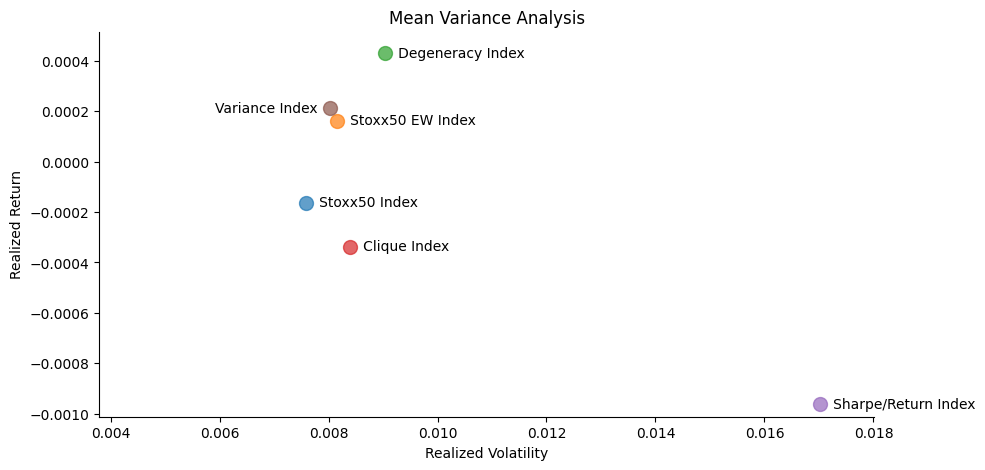

In [36]:
#mean variance analysis
comparison={}

for i in ['SX5E','equal','degeneracy','clique','sharpe','variance','return']:
    comparison[i]=(data_out[i].pct_change().dropna().std(),
          data_out[i].pct_change().dropna().mean())

#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.scatter(comparison['SX5E'][0],comparison['SX5E'][1],
            s=100,alpha=0.7)
plt.annotate(xy=(comparison['SX5E'][0],comparison['SX5E'][1]),
             text='   Stoxx50 Index',ha='left',va='center')
plt.scatter(comparison['equal'][0],comparison['equal'][1],
            s=100,alpha=0.7)
plt.annotate(xy=(comparison['equal'][0],comparison['equal'][1]),
             text='   Stoxx50 EW Index',ha='left',va='center')
plt.scatter(comparison['degeneracy'][0],comparison['degeneracy'][1],
            s=100,alpha=0.7)
plt.annotate(xy=(comparison['degeneracy'][0],comparison['degeneracy'][1]),
             text='   Degeneracy Index',ha='left',va='center')
plt.scatter(comparison['clique'][0],comparison['clique'][1],
            s=100,alpha=0.7)
plt.annotate(xy=(comparison['clique'][0],comparison['clique'][1]),
             text='   Clique Index',ha='left',va='center')
plt.scatter(comparison['sharpe'][0],comparison['sharpe'][1],
            s=100,alpha=0.7)
plt.annotate(xy=(comparison['sharpe'][0],comparison['sharpe'][1]),
             text='   Sharpe/Return Index',ha='left',va='center')
plt.scatter(comparison['variance'][0],comparison['variance'][1],
            s=100,alpha=0.7)
plt.annotate(xy=(comparison['variance'][0],comparison['variance'][1]),
             text='Variance Index   ',ha='right',va='center')

plt.xlim(min([i[0] for i in comparison.values()])*0.5,
         max([i[0] for i in comparison.values()])*1.05)

plt.ylim(min([i[1] for i in comparison.values()])*1.05,
         max([i[1] for i in comparison.values()])*1.2)

plt.title('Mean Variance Analysis')
plt.xlabel('Realized Volatility')
plt.ylabel('Realized Return')
plt.show()

#Out-of-Sample data results

Pour la comparaison des données hors échantillon, les choses prennent une tournure dramatique. L'indice de dégénérescence semble surclasser tous les autres indices. La star de l'échantillon, l'indice Sharpe/Rendement, affiche les pires performances. Vous pensez peut-être que je fais de la sélection. Si vous modifiez l'horizon temporel des données d'entraînement et de test, vous constaterez que l'indice de dégénérescence surpasse toujours l'indice Stoxx50 et l'indice Stoxx50 EW, quel que soit le sentiment du marché. Dans un marché baissier, l'indice Sharpe/Rendement est pratiquement inutile. Il s'aligne sur les critiques de la théorie moderne du portefeuille. Les mesures historiques du rendement et de la volatilité des actifs ne se traduisent pas par une performance garantie dans le futur. Elles échouent souvent dans de nouvelles circonstances, en particulier lorsque quelque chose ne s'est jamais produit dans l'histoire. Malgré les différentes méthodes de fractionnement des tests de formation, l'indice de variance et l'indice de dégénérescence sont les plus performants. La diversification conserve l'avantage d'une faible volatilité, même si elle souffre d'un ratio de Sharpe et d'un rendement plus faibles dans un marché haussier.